In [3]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

data_dir = 'D:/Major Project/Dataset/New_Dataset'
batch_size = 32
target_size = (224, 224)

image_paths = []
labels = []
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    workers=1
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=1
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=1
)

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Found 58400 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Steps per epoch: 1825
Validation steps: 229


In [5]:
def build_model(num_classes):
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model(num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Initial Model (All Base Layers Frozen):")
print(f"Total parameters: {model.count_params()}")
print(f"Trainable parameters: {sum([w.shape.num_elements() for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {model.count_params() - sum([w.shape.num_elements() for w in model.trainable_weights])}")

csv_logger_initial = CSVLogger('D:/Major Project/Models/VGG16/training_history_initial.csv', separator=',', append=False)
early_stopping_initial = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint_initial = ModelCheckpoint('D:/Major Project/Models/VGG16/best_initial_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)

history_initial = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping_initial, model_checkpoint_initial, csv_logger_initial],
    verbose=1
)

Initial Model (All Base Layers Frozen):
Total parameters: 14789769
Trainable parameters: 75081
Non-trainable parameters: 14714688
Epoch 1/50
1825/1825 [==============================] - 1426s 774ms/step - loss: 1.0750 - accuracy: 0.6780 - val_loss: 0.5989 - val_accuracy: 0.7960
Epoch 2/50
1825/1825 [==============================] - 1606s 880ms/step - loss: 0.5912 - accuracy: 0.8008 - val_loss: 0.5061 - val_accuracy: 0.8207
Epoch 3/50
1825/1825 [==============================] - 1150s 630ms/step - loss: 0.5147 - accuracy: 0.8230 - val_loss: 0.4526 - val_accuracy: 0.8453
Epoch 4/50
1825/1825 [==============================] - 1069s 586ms/step - loss: 0.4723 - accuracy: 0.8375 - val_loss: 0.4549 - val_accuracy: 0.8442
Epoch 5/50
1825/1825 [==============================] - 1054s 577ms/step - loss: 0.4434 - accuracy: 0.8476 - val_loss: 0.4355 - val_accuracy: 0.8542
Epoch 6/50
1825/1825 [==============================] - 1063s 582ms/step - loss: 0.4224 - accuracy: 0.8544 - val_loss: 0.4036

In [9]:
for layer in model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

csv_logger_finetune = CSVLogger('D:/Major Project/Models/VGG16/training_history_finetune.csv', separator=',', append=False)
early_stopping_finetune = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
model_checkpoint_finetune = ModelCheckpoint('D:/Major Project/Models/VGG16/best_finetune_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping_finetune, model_checkpoint_finetune, csv_logger_finetune],
    verbose=1
)

Epoch 1/20
1825/1825 [==============================] - 1209s 662ms/step - loss: 0.2743 - accuracy: 0.9047 - val_loss: 0.2958 - val_accuracy: 0.9074
Epoch 2/20
1825/1825 [==============================] - 1684s 922ms/step - loss: 0.2556 - accuracy: 0.9101 - val_loss: 0.2875 - val_accuracy: 0.9081
Epoch 3/20
1825/1825 [==============================] - 1438s 788ms/step - loss: 0.2526 - accuracy: 0.9114 - val_loss: 0.2837 - val_accuracy: 0.9093
Epoch 4/20
1825/1825 [==============================] - 1328s 728ms/step - loss: 0.2486 - accuracy: 0.9135 - val_loss: 0.2799 - val_accuracy: 0.9107
Epoch 5/20
1825/1825 [==============================] - 1001s 548ms/step - loss: 0.2472 - accuracy: 0.9139 - val_loss: 0.2780 - val_accuracy: 0.9122
Epoch 6/20
1825/1825 [==============================] - 1046s 573ms/step - loss: 0.2454 - accuracy: 0.9138 - val_loss: 0.2766 - val_accuracy: 0.9122
Epoch 7/20
1825/1825 [==============================] - 1012s 554ms/step - loss: 0.2432 - accuracy: 0.9148

In [16]:
model.save_weights('D:/Major Project/mobilenet/all_weights.keras')
model.save('D:/Major Project/mobilenet/final_model.keras')

In [25]:
import math
test_steps = math.ceil(len(test_df) / batch_size)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

229/229 [==============================] - 50s 216ms/step - loss: 0.2804 - accuracy: 0.9104
Test Loss: 0.2804, Test Accuracy: 0.9104


229/229 [==============================] - 49s 212ms/step


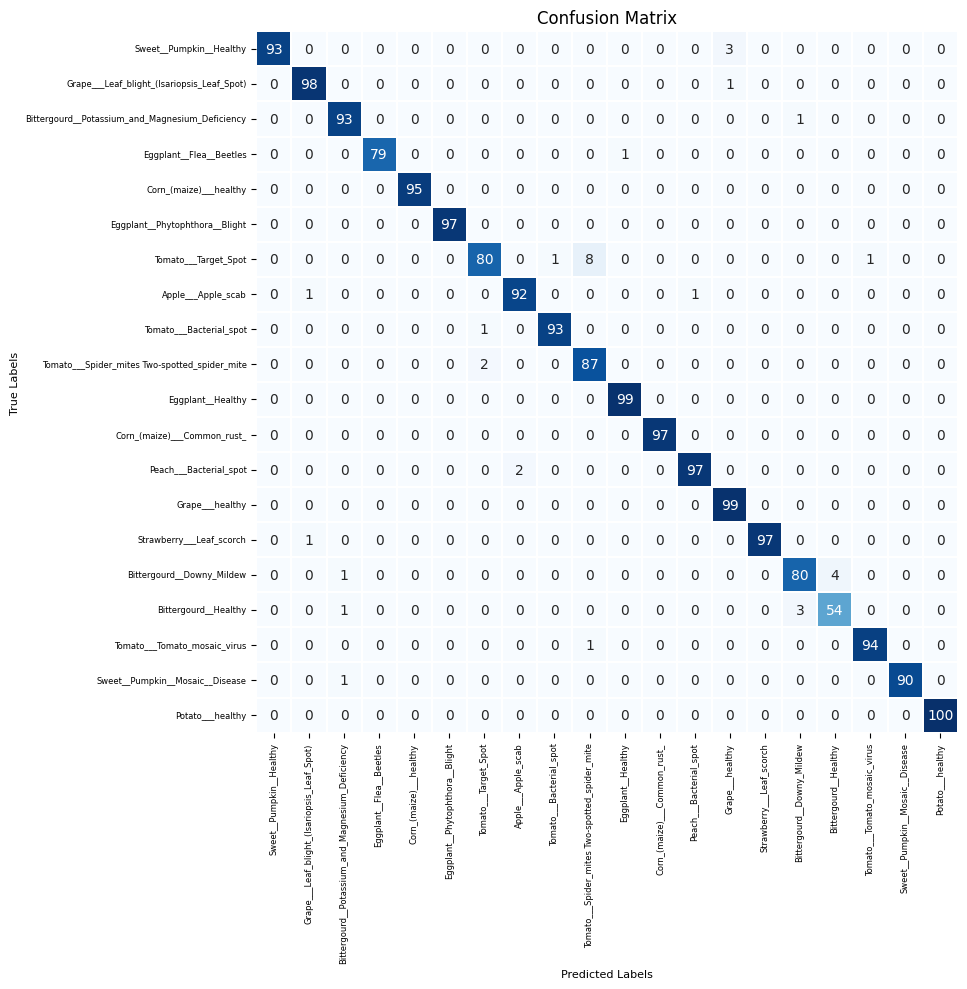

In [48]:
# Generate confusion matrix for random 20 labels
import random
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test_generator.class_indices.keys())
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
if len(y_true) != len(y_pred_classes):
    print("Warning: Mismatch in lengths. Truncating y_true to match y_pred_classes.")
    y_true = y_true[:len(y_pred_classes)]
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

num_classes_to_show = 20
if len(class_labels) < num_classes_to_show:
    num_classes_to_show = len(class_labels)

random_classes = random.sample(class_labels, num_classes_to_show)
random_class_indices = [class_labels.index(cls) for cls in random_classes]
mask_true = np.isin(y_true, random_class_indices)

filtered_y_true_temp = y_true[mask_true]
filtered_y_pred_temp = y_pred_classes[mask_true]
mask_pred = np.isin(filtered_y_pred_temp, random_class_indices)

filtered_y_true = filtered_y_true_temp[mask_pred]
filtered_y_pred_classes = filtered_y_pred_temp[mask_pred]

label_mapping = {idx: i for i, idx in enumerate(random_class_indices)}
filtered_y_true_mapped = np.array([label_mapping[label] for label in filtered_y_true])
filtered_y_pred_mapped = np.array([label_mapping[label] for label in filtered_y_pred_classes])

cm = confusion_matrix(filtered_y_true_mapped, filtered_y_pred_mapped)

plt.figure(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=random_classes, yticklabels=random_classes,
            cbar=False, linewidths=0.3, square=True)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Predicted Labels', fontsize=8)
plt.ylabel('True Labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG16/confusion_matrix_vgg16_random_samples.png')

In [50]:
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('D:/Major Project/resnet/classification_report.csv')
print("Classification report saved to 'D:/Major Project/resnet/classification_report.csv'")
print("\nClassification Report:")
print(report_df)

predictions_df = pd.DataFrame({
    'True_Label': [class_labels[i] for i in y_true],
    'Predicted_Label': [class_labels[i] for i in y_pred_classes],
    'Confidence': np.max(y_pred, axis=1)
})
predictions_df.to_csv('D:/Major Project/Models/VGG16/test_predictions.csv', index=False)
print("Test predictions saved to 'D:/Major Project/Models/VGG16/test_predictions.csv'")

Classification report saved to 'D:/Major Project/resnet/classification_report.csv'

Classification Report:
                              precision    recall  f1-score      support
Apple___Apple_scab             0.920000  0.920000  0.920000   100.000000
Apple___Black_rot              0.969697  0.960000  0.964824   100.000000
Apple___Cedar_apple_rust       0.940000  0.940000  0.940000   100.000000
Apple___healthy                0.930000  0.930000  0.930000   100.000000
Bittergourd__Downy_Mildew      0.800000  0.800000  0.800000   100.000000
...                                 ...       ...       ...          ...
Tomato___Tomato_mosaic_virus   0.912621  0.940000  0.926108   100.000000
Tomato___healthy               0.892157  0.910000  0.900990   100.000000
accuracy                       0.910411  0.910411  0.910411     0.910411
macro avg                      0.910674  0.910411  0.909806  7300.000000
weighted avg                   0.910674  0.910411  0.909806  7300.000000

[76 rows x 4 col

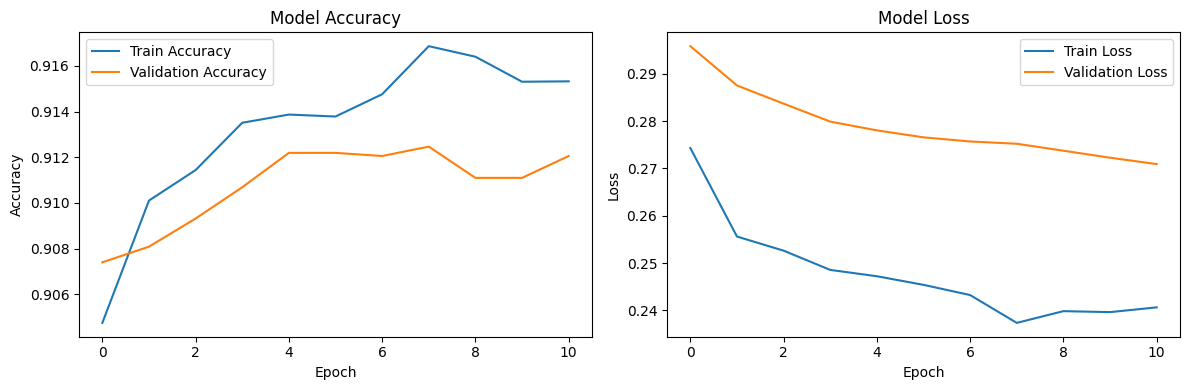

In [60]:
# Training history for fine-tuned epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG16/training_history_fine.png')
plt.show()

Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'
Initial training epochs: 30
Fine-tuning epochs: 11
Total epochs: 41
Training history plot saved to 'D:/Major Project/Models/VGG16/training_history_combined.png'


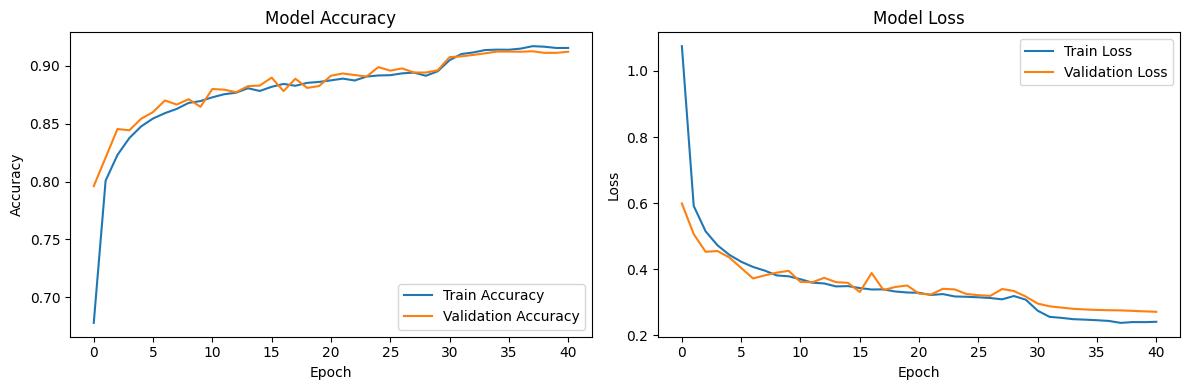

In [64]:
#Training history for both initial and fine-tuned epochs
try:
    history_initial_df = pd.read_csv('D:/Major Project/Models/VGG16/training_history_initial.csv')
    history_fine_df = pd.read_csv('D:/Major Project/Models/VGG16/training_history_finetune.csv')
    print("Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'")
except Exception as e:
    print(f"Error loading history CSVs: {e}")
    print("Please ensure 'training_history_initial.csv' and 'training_history_fine_initial.csv' exist in 'D:/Major Project/Models/VGG16'")
    exit(1)

required_columns = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
if not all(col in history_initial_df.columns for col in required_columns) or \
   not all(col in history_fine_df.columns for col in required_columns):
    print("Error: CSV files must contain columns: 'accuracy', 'val_accuracy', 'loss', 'val_loss'")
    exit(1)

history_initial = {
    'accuracy': history_initial_df['accuracy'].tolist(),
    'val_accuracy': history_initial_df['val_accuracy'].tolist(),
    'loss': history_initial_df['loss'].tolist(),
    'val_loss': history_initial_df['val_loss'].tolist()
}
history_finetune = {
    'accuracy': history_fine_df['accuracy'].tolist(),
    'val_accuracy': history_fine_df['val_accuracy'].tolist(),
    'loss': history_fine_df['loss'].tolist(),
    'val_loss': history_fine_df['val_loss'].tolist()
}
print(f"Initial training epochs: {len(history_initial['accuracy'])}")
print(f"Fine-tuning epochs: {len(history_finetune['accuracy'])}")
print(f"Total epochs: {len(history_initial['accuracy']) + len(history_fine['accuracy'])}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_initial['accuracy'] + history_finetune['accuracy'], label='Train Accuracy')
plt.plot(history_initial['val_accuracy'] + history_finetune['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_initial['loss'] + history_finetune['loss'], label='Train Loss')
plt.plot(history_initial['val_loss'] + history_finetune['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG16/training_history_combined.png')
print("Training history plot saved to 'D:/Major Project/Models/VGG16/training_history_combined.png'")